In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from lobio.simulator import Simulator
from lobio.accounting.pnl_counter import PnL_Counter
from lobio.model.avellaneda_stoikov_model import AvellanedaStoikov
from lobio.lob.limit_order import LimitOrder
from lobio.lob.order_book import TraderId
from lobio.lob.order_book import OrderBook

%load_ext autoreload
%autoreload 2

In [2]:
diffs_file = "../data/diffs_prepared.json"
init_lob_file = "../data/init_lob_prepared.json"
trades_file = "../data/trades_prepared.csv"

with open(diffs_file, "r", encoding="utf-8") as file:
    diffs = json.load(file)
with open(init_lob_file, "r", encoding="utf-8") as file:
    init_lob = json.load(file)

trades = pd.read_csv(trades_file)

In [3]:
trades_by_diff = []

trades_index = 0
for v in diffs:
    time_to = v[0]
    trades_after_diff = []
    cur_trade = trades.iloc[trades_index]
    while (cur_trade["timestamp"] <= time_to) and (trades_index + 1 < len(trades)):
        limit_order = LimitOrder(
            float(cur_trade["price"]),
            float(cur_trade["amount"]),
            int(cur_trade["side"]),
            TraderId.MARKET,
        )
        trades_after_diff.append((cur_trade["timestamp"], limit_order))
        trades_index += 1
        cur_trade = trades.iloc[trades_index]
    trades_by_diff.append(trades_after_diff)

In [4]:
t0 = diffs[0][0]
T = diffs[-1][0] + 100

pnl_counter = PnL_Counter()
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=2, sigma=3, gamma=0.5, q_max=0.5)
simulator = Simulator(diffs, trades_by_diff, init_lob, alpha, pnl_counter, T)

In [5]:
run_data = simulator.run_maker(market_latency=10)

100%|██████████| 9904/9904 [00:02<00:00, 4336.58it/s]


agent asset amount - 0.7471, agent money amount - -1700.74


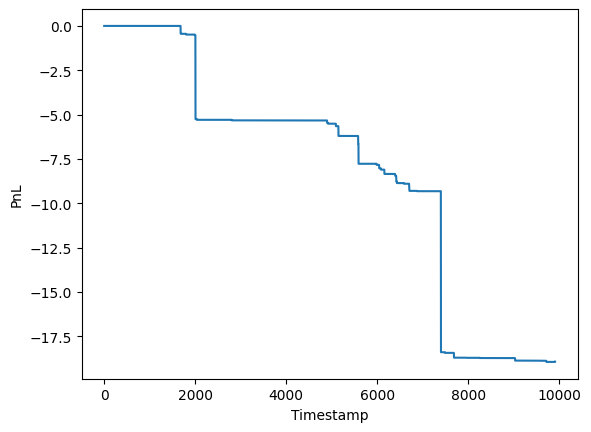

In [6]:
print(f"agent asset amount - {run_data[1]}, agent money amount - {run_data[2]}")
plt.plot(run_data[0])
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.show()

In [7]:
run_data[1] * simulator.order_book.ask_price() + run_data[2]

-244.07430399999998

In [8]:
run_data[1], simulator.order_book.ask_price(), run_data[2]

(0.7471, 1949.76, -1700.74)